In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# loading in and transforming data
import os
os.chdir('/content/drive/MyDrive/MangaColoring/cyclegan/')

import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# visualizing data
import matplotlib.pyplot as plt
import numpy as np
import warnings

import torch.nn.functional as F
import torch.nn as nn

from helpers import save_samples, checkpoint

%matplotlib inline

In [3]:
def get_data_loader(image_type, image_dir='../Berserk/', 
                    image_size=[256,256], batch_size=8, num_workers=0, augment_training=True):
    
    # resize and normalize the images
    if augment_training:
        transform_train = transforms.Compose([transforms.RandomApply([transforms.ColorJitter(saturation=(0., 1.))], p=0.5),
                                              transforms.RandomApply([transforms.RandomAffine((10, 50), translate=None, scale=None, shear=None, resample=0, fillcolor=0)], p=0.2),
                                              transforms.RandomHorizontalFlip(p=0.4),
                                              transforms.RandomVerticalFlip(p=0.2),
                                              transforms.RandomResizedCrop(image_size, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2),
                                              transforms.Resize(image_size),
                                              transforms.ToTensor()])
    
    else:
        transform_train = transforms.Compose([transforms.Resize(image_size),
                                              transforms.ToTensor()])
        
    transform_test = transforms.Compose([transforms.Resize(image_size),
                                              transforms.ToTensor()])

    # get training and test directories
    image_path = './' + image_dir
    train_path = os.path.join(image_path, image_type)
    test_path = os.path.join(image_path, f'{image_type}_test')

    # define datasets using ImageFolder
    train_dataset = datasets.ImageFolder(train_path, transform_train)
    test_dataset = datasets.ImageFolder(test_path, transform_test)

    # create and return DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader

In [4]:
dataloader_bw, test_dataloader_bw = get_data_loader(image_type='bw')
dataloader_rgb, test_dataloader_rgb = get_data_loader(image_type='rgb')

In [5]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

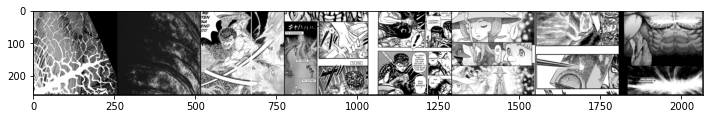

In [6]:
dataiter = iter(dataloader_bw)
images, _ = dataiter.next()

fig = plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(images))

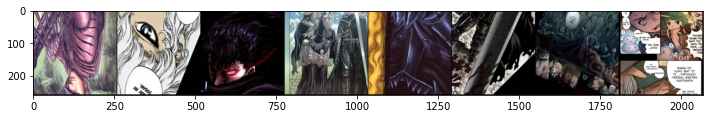

In [7]:
dataiter = iter(dataloader_rgb)
images, _ = dataiter.next()

fig = plt.figure(figsize=(12,8))
imshow(torchvision.utils.make_grid(images))

In [8]:
# current range
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())

Min:  tensor(0.0353)
Max:  tensor(1.)


In [9]:
# helper scale function
def scale(x, feature_range=(-1, 1)):
    '''This function assumes that the input x is already scaled from 0-1.'''
    
    # scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

# scaled range
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Scaled min:  tensor(-0.9294)
Scaled max:  tensor(1.)


In [10]:
# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)


def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [11]:
class Discriminator(nn.Module):
    
    def __init__(self, conv_dim=64):
        super().__init__()

        self.cv1 = conv(3, conv_dim, 3, batch_norm=False)
        self.cv2 = conv(conv_dim, conv_dim*2, 4)              # (256, 128)
        self.cv3 = conv(conv_dim*2, conv_dim*4, 4)            # (128, 64) 
        self.cv4 = conv(conv_dim*4, conv_dim*8, 4)            # (64, 32)
        self.cv5 = conv(conv_dim*8, conv_dim*8, 4)            # (64, 32)
        self.cv6 = conv(conv_dim*8, 1, 4, batch_norm=False)   # (32, 1)

    def initialize_weights(self):
      for m in self.modules():
          if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
              torch.nn.init.normal_(m.weight, mean=0.0, std=0.2)
        
    def forward(self, x):
        x = F.relu(self.cv1(x))
        x = F.relu(self.cv2(x))
        x = F.relu(self.cv3(x))
        x = F.relu(self.cv4(x))
        x = F.relu(self.cv5(x))
        
        x = self.cv6(x)
        
        return x

In [12]:
class ResidualBlock(nn.Module):
    """Defines a residual block.
       This adds an input x to a convolutional layer (applied to x) with the same size input and output.
       These blocks allow a model to learn an effective transformation from one domain to another.
    """
    def __init__(self, conv_dim):
        super().__init__()
        # conv_dim = number of inputs  
        self.cv = conv(in_channels=conv_dim, out_channels=conv_dim, kernel_size=3, stride=1, padding=1, batch_norm=True)        
        
    def forward(self, x):
        # apply a ReLu activation the outputs of the first layer
        # return a summed output, x + resnet_block(x)
        out_1 = F.leaky_relu(self.cv(x), negative_slope=0.2)
        out_2 = x + self.cv(out_1)
        return out_2

In [13]:
class CycleGenerator(nn.Module):
    
    def __init__(self, conv_dim=64, n_res_blocks=9):
        super().__init__()

        # Encoder part
                                                                                     # (W-F+2P)/S+1
        self.cv1 = conv(3, conv_dim,             kernel_size=7, stride=1, padding=1) # (256, 251)
        self.cv2 = conv(conv_dim, conv_dim*2,    kernel_size=3, stride=2, padding=1) # (251,126)
        self.cv3 = conv(conv_dim*2, conv_dim*4,  kernel_size=3, stride=2, padding=1) # (126,63.5)->(126,63)

        # Resnet part
        res_layers = []
        for layer in range(n_res_blocks):
            res_layers.append(ResidualBlock(conv_dim*4))
        
        self.res = nn.Sequential(*res_layers)

        # Decoder part
                                                                                              # (W-1)S-2P+F if (W-F+2P)/S is an integer
        self.dcv3 = deconv(conv_dim*4, conv_dim*2,  kernel_size=3, stride=2, padding=1)
        self.dcv4 = deconv(conv_dim*2, conv_dim,    kernel_size=3, stride=2, padding=1)
        self.dcv5 = deconv(conv_dim, 3,             kernel_size=7, stride=1, padding=1, batch_norm=False)

        self.asym_pad = nn.ZeroPad2d((0, 1, 0, 1))

        self.initialize_weights()

    def initialize_weights(self):
      for m in self.modules():
          if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
              torch.nn.init.normal_(m.weight, mean=0.0, std=0.2)
        
    def forward(self, x):
        x = F.leaky_relu(self.cv1(x), negative_slope=0.2)
        x = F.leaky_relu(self.cv2(x), negative_slope=0.2)
        x = F.leaky_relu(self.cv3(x), negative_slope=0.2)

        res2 = x.detach().clone()

        x = self.res(x)

        x += res2
        
        x = F.leaky_relu(self.dcv3(x), negative_slope=0.2)
        x = self.asym_pad(x)
        x = F.leaky_relu(self.dcv4(x), negative_slope=0.2)
        x = self.asym_pad(x)
        x = F.tanh(self.dcv5(x))

        return x

In [14]:
def create_model(g_conv_dim=32, d_conv_dim=32, n_res_blocks=9, load=False):
    """Builds the generators and discriminators."""

    G_XtoY = CycleGenerator(conv_dim=g_conv_dim)
    G_YtoX = CycleGenerator(conv_dim=g_conv_dim)
    D_X = Discriminator(conv_dim=d_conv_dim)
    D_Y = Discriminator(conv_dim=d_conv_dim)
    
    if load:
        state_dict = torch.load('checkpoints_cyclegan/G_XtoY.pkl')
        G_XtoY.load_state_dict(state_dict)
        state_dict = torch.load('checkpoints_cyclegan/G_YtoX.pkl')
        G_YtoX.load_state_dict(state_dict)
        state_dict = torch.load('checkpoints_cyclegan/D_X.pkl')
        D_X.load_state_dict(state_dict)
        state_dict = torch.load('checkpoints_cyclegan/D_Y.pkl') 
        D_Y.load_state_dict(state_dict)

    # move models to GPU, if available
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        G_XtoY.to(device)
        G_YtoX.to(device)
        D_X.to(device)
        D_Y.to(device)
        print('Models moved to GPU.')
    else:
        print('Only CPU available.')

    return G_XtoY, G_YtoX, D_X, D_Y

In [15]:
G_XtoY, G_YtoX, D_X, D_Y = create_model(load=False)

Models moved to GPU.


In [16]:
def real_mse_loss(D_out, lambda_weight=1):
    return lambda_weight * torch.mean((D_out - 1)**2)
        
def fake_mse_loss(D_out, lambda_weight=1):
    return lambda_weight * torch.mean(D_out**2)

def identity_loss(target_im, generator_im, lambda_weight=5):
    return lambda_weight * (torch.mean(torch.abs(target_im - generator_im)))

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight=10):
    reconstructed_loss = torch.mean(torch.abs(reconstructed_im - real_im))
    return lambda_weight * reconstructed_loss

In [17]:
import torch.optim as optim

# hyperparams for Adam optimizer
lr=0.0002
beta1=0.5
beta2=0.999

g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())

g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])

In [18]:
def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, 
                  n_epochs=1000):
    
    # keep track of losses over time
    losses = []

    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)

    # Get some fixed data from domains X and Y for sampling.
    fixed_X = test_iter_X.next()[0]
    fixed_X = test_iter_X.next()[0]
    fixed_Y = test_iter_Y.next()[0]
    fixed_Y = test_iter_Y.next()[0]
    fixed_X = scale(fixed_X)
    fixed_Y = scale(fixed_Y)

    # batches per epoch
    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)
    batches_per_epoch = min(len(iter_X), len(iter_Y))

    for epoch in range(1, n_epochs+1):

        # Reset iterators for each epoch
        if epoch % batches_per_epoch == 0:
            iter_X = iter(dataloader_X)
            iter_Y = iter(dataloader_Y)

        images_X, _ = iter_X.next()
        images_X = scale(images_X) # make sure to scale to a range -1 to 1

        images_Y, _ = iter_Y.next()
        images_Y = scale(images_Y)
        
        # move images to GPU if available
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        images_X = images_X.to(device)
        images_Y = images_Y.to(device)


        # ============================================
        #                    TRAIN
        # ============================================

        g_optimizer.zero_grad()
        d_x_optimizer.zero_grad()
        d_y_optimizer.zero_grad()

        ##   Train Generators   ##

        # 1. Generate images
        fake_images_X = G_YtoX(images_Y)
        fake_images_Y = G_XtoY(images_X)
        identity_images_X = G_YtoX(images_X)
        identity_images_Y = G_XtoY(images_Y)
        reconstructed_images_X = G_YtoX(fake_images_Y)
        reconstructed_images_Y = G_XtoY(fake_images_X)

        # 2. Compute loss
        g_x_adv_loss = real_mse_loss(D_X(fake_images_X))
        g_y_adv_loss = real_mse_loss(D_Y(fake_images_Y))
        
        g_x_id_loss = identity_loss(images_X, identity_images_X)
        g_y_id_loss = identity_loss(images_Y, identity_images_Y)

        cycle_loss_X = cycle_consistency_loss(images_X, reconstructed_images_X)        
        cycle_loss_Y = cycle_consistency_loss(images_Y, reconstructed_images_Y)

        # 3. Backprop
        g_total_loss = g_x_adv_loss + g_y_adv_loss + g_x_id_loss + g_y_id_loss + cycle_loss_X + cycle_loss_Y
        g_total_loss.backward()
        g_optimizer.step()

        ##   Train D_X   ##

        # 1. Compute the discriminator losses on real images
        d_x_real_loss = real_mse_loss(D_X(images_X))
        
        # 2. Generate fake images that look like domain X based on real images in domain Y
        fake_images_X = G_YtoX(images_Y)

        # 3. Compute the fake loss for D_X
        d_x_fake_loss = fake_mse_loss(D_X(fake_images_X))

        # 4. Compute the total loss and perform backprop
        d_x_loss = d_x_real_loss + d_x_fake_loss
        d_x_loss.backward(retain_graph=True)
        d_x_optimizer.step()
        

        ##   Train D_Y   ##

        d_y_real_loss = real_mse_loss(D_Y(images_Y))
        fake_images_Y = G_XtoY(images_X)
        d_y_fake_loss = fake_mse_loss(D_Y(fake_images_Y))
        d_y_loss = (d_y_real_loss + d_y_fake_loss)
        d_y_loss.backward(retain_graph=True)
        d_y_optimizer.step()       
        
        # Print the log info
        print_every=10
        if epoch % print_every == 0:
            losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
            print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
                    epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))

            
        # Save the generated samples
        sample_every=100
        if epoch % sample_every == 0:
            G_YtoX.eval()
            G_XtoY.eval()
            save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=8)
            G_YtoX.train()
            G_XtoY.train()

        checkpoint_every=100
        if epoch % checkpoint_every == 0:
             checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y)

    return losses

In [19]:
n_epochs = 2000

losses = training_loop(dataloader_bw, dataloader_rgb, test_dataloader_bw, test_dataloader_rgb, n_epochs=n_epochs)

Epoch [   10/ 2000] | d_X_loss: 0.6449 | d_Y_loss: 0.6745 | g_total_loss: 25.0264
Epoch [   20/ 2000] | d_X_loss: 0.5456 | d_Y_loss: 0.5151 | g_total_loss: 22.0072
Epoch [   30/ 2000] | d_X_loss: 0.4468 | d_Y_loss: 0.4727 | g_total_loss: 18.8293
Epoch [   40/ 2000] | d_X_loss: 0.4151 | d_Y_loss: 0.4709 | g_total_loss: 16.3370
Epoch [   50/ 2000] | d_X_loss: 0.4062 | d_Y_loss: 0.3729 | g_total_loss: 16.0007
Epoch [   60/ 2000] | d_X_loss: 0.3502 | d_Y_loss: 0.2782 | g_total_loss: 14.5026
Epoch [   70/ 2000] | d_X_loss: 0.3010 | d_Y_loss: 0.3797 | g_total_loss: 13.6673
Epoch [   80/ 2000] | d_X_loss: 0.3465 | d_Y_loss: 0.3774 | g_total_loss: 11.9950
Epoch [   90/ 2000] | d_X_loss: 0.3045 | d_Y_loss: 0.3127 | g_total_loss: 14.7742
Epoch [  100/ 2000] | d_X_loss: 0.6019 | d_Y_loss: 0.3237 | g_total_loss: 13.6577
Saved samples_cyclegan/X-Y-sample-000100.png
Saved samples_cyclegan/Y-X-sample-000100.png
Epoch [  110/ 2000] | d_X_loss: 0.3714 | d_Y_loss: 0.2446 | g_total_loss: 13.5470
Epoch [ 

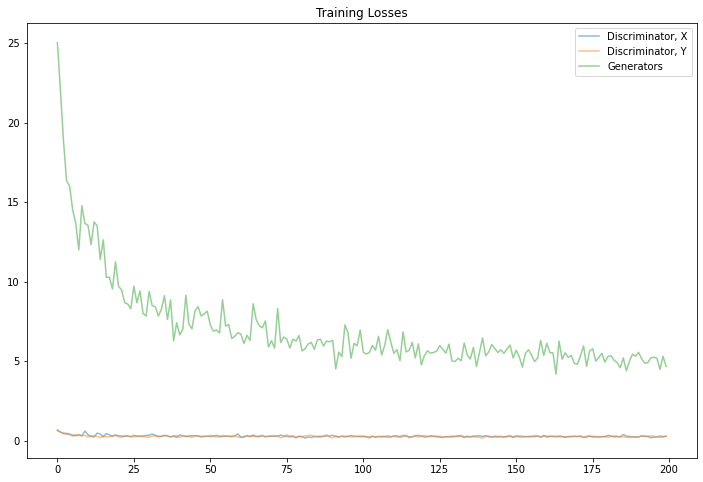

In [20]:
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator, X', alpha=0.5)
plt.plot(losses.T[1], label='Discriminator, Y', alpha=0.5)
plt.plot(losses.T[2], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()

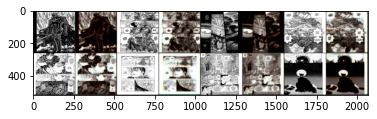

In [21]:
img = plt.imread('samples_cyclegan/X-Y-sample-002000.png')
plt.imshow(img)